<a href="https://colab.research.google.com/github/Spinkk/Implementing-ANNs-with-Tensorflow/blob/main/06/ANNw06_Minseok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime


# 1. Data set
Analogous to last week

In [94]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

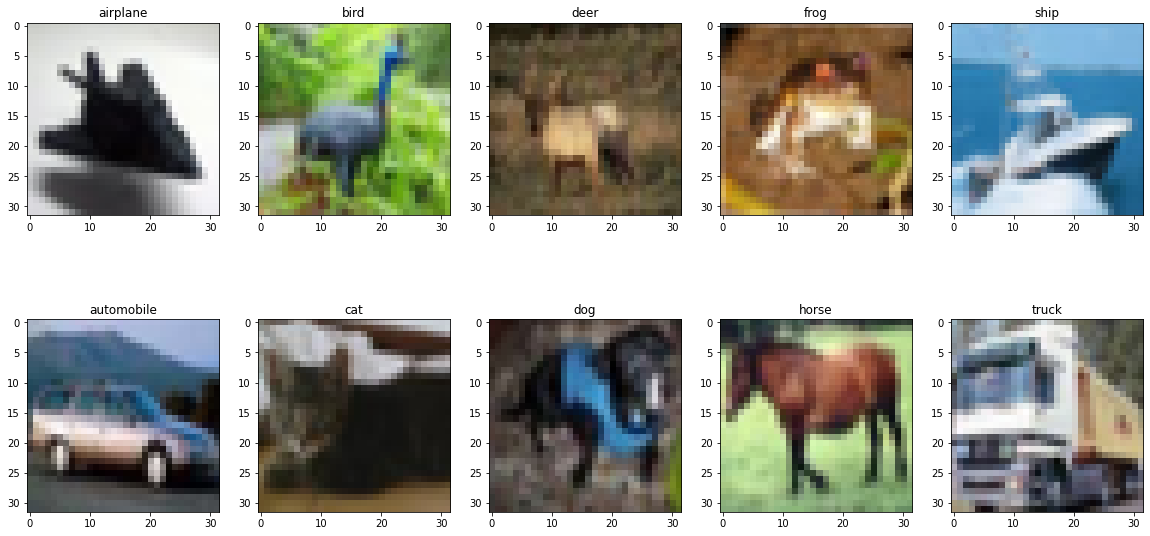

In [95]:
# visualize one example from each image class

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

for category_index in range(10):
  ri = category_index % 2
  ci = category_index // 2
  data_index = np.where(y_train==category_index)[0][0]  # get first image with correct label 
  ax[ri,ci].imshow(x_train[data_index])
  ax[ri,ci].set_title(labels[category_index])

In [96]:
# one-hot encoding labels
y_train = np.eye(10)[y_train.reshape(-1)]
y_test = np.eye(10)[y_test.reshape(-1)]

# standardize input data
x_train = tf.image.per_image_standardization(x_train)
x_test = tf.image.per_image_standardization(x_test)

# cast to float32 so that tf.nn.conv2d is happy
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)


# batch, shuffle, prefetch
def preprocess(input, label, batch_size=None, buffer_size=None, augment=False):
  '''
  zip separate input and label and do standard preprocessing
  :param input: np.array, input to network
  :param label: np.array, correct label in supervised learning
  :param batch_size: int, batch such that 100 updates per epoch in default
  :param buffer_size: int, max buff size in default
  :param augment: tf.keras.Sequential, layers to do data augmentation
  :returns: tf.dataset
  '''

  if batch_size == None:  
    batch_size = input.shape[0]//100
  if buffer_size == None:  
    buffer_size = input.shape[0] 

  dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(input),
                                 tf.data.Dataset.from_tensor_slices(label)))
  dataset = dataset.shuffle(buffer_size)  # shuffle before batch
  dataset = dataset.batch(batch_size)
  
  if augment:
    dataset = dataset.map(lambda x, y: (augment(x, training=True), y), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset


# # define data augmentation processes
# data_augmentation_layer = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#                                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])


train_ds = preprocess(x_train, y_train, batch_size=64, augment=False)
test_ds = preprocess(x_test, y_test, batch_size=1, augment=False)

# 2.2. DenseNet

In [101]:
class Transition(tf.keras.layers.Layer):
  def __init__(self, filter_num, input_size, activation='relu'):
    super(Transition, self).__init__()
    self.bottleneck = tf.keras.layers.Conv2D(filter_num, (1,1), input_shape=input_size)
    self.batchnorm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.Activation(activation)
    self.pool = tf.keras.layers.AveragePooling2D()

  @tf.function
  def call(self, x, training=False):
    # (width x height x channel)
    x = self.bottleneck(x)
    x = self.batchnorm(x, training)
    x = self.activation(x)
    # (width x height x filter)
    x = self.pool(x)
    # (width/2 x height/2 x filter)
    return x


class DenseLayer(tf.keras.layers.Layer):
  def __init__(self, growth_rate, input_size, kernel_size, activation):
    super(DenseLayer, self).__init__()
    self.bottleneck = tf.keras.layers.Conv2D(128, (1,1), input_shape=input_size)  #TODO: why 128?
    self.bn0 = tf.keras.layers.BatchNormalization()
    self.acti0 =tf.keras.layers.Activation(activation)

    self.conv = tf.keras.layers.Conv2D(growth_rate, kernel_size, padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.acti1 =tf.keras.layers.Activation(activation)

  @tf.function
  def call(self, x, training=False):
    # (width x height x channel)
    x0 = self.bottleneck(x)
    x0 = self.bn0(x0, training)
    x0 = self.acti0(x0)
    # (width x height x 128)
    x1 = self.conv(x0)
    x1 = self.bn1(x1, training)
    x1 = self.acti1(x1)
    # (width x height x growth rate)
    x = tf.keras.layers.Concatenate(axis=-1)([x0,x1])
    # (width x height x channel+growth rate)
    return x


class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, num_DL, input_size, growth_rate=2, kernel_size=(3,3), activation='relu'):
    super(DenseBlock, self).__init__()
    self.num_DL = num_DL  # TODO: could be done better
    self.dense_layers = [DenseLayer(growth_rate, input_size, kernel_size, activation) for _ in range(num_DL)]

  @tf.function
  def call(self, x, training=False):
    for i in range(self.num_DL):  # TODO: could be done better with list comp
      # (width x height x channel)
      x = self.dense_layers[i](x, training)  
      # (width x height x growth_rate*num_DL)
    return x

In [114]:
class DenseNet(tf.keras.Model):
  def __init__(self, k0=4):
    super(DenseNet, self).__init__()
    gr = 2  # growth rate=2?
    input_size = (32,32,3)
    # (32 x 32 x 3)
    self.conv0 = tf.keras.layers.Conv2D(filters=k0, kernel_size=(1,1), input_shape=input_size)  # just to get good channel dim.
    # (32 x 32 x 4)
    
    self.dense0 = DenseBlock(2, (32,32,4))  # TODO: derive automatically from input_size 
    depth = k0 + gr*2  # k0 + k * (num_DL)
    # (32 x 32 x 8)
    self.trans0 = Transition(depth, (32,32,8))  # should be halved
    # (16 x 16 x 8)
    
    self.dense1 = DenseBlock(4, (16,16,8))
    depth = depth + gr*4
    # (16 x 16 x 16)
    self.trans1 = Transition(depth, (16,16,16))
    # (8 x 8 x 16)

    self.dense2 = DenseBlock(8, (8,8,16))
    depth = depth + gr*8
    # (8 x 8 x 32)
    self.trans2 = Transition(depth, (8,8,32))
    # (4 x 4 x 32)

    self.dense3 = DenseBlock(16, (4,4,32))
    depth = depth +gr*16
    # (4 x 4 x 64)

    self.pool_end = tf.keras.layers.AveragePooling2D(pool_size=(4,4))  # depend on input size
    # (1 x 1 x 64)
    self.full = tf.keras.layers.Dense(500, activation='relu')
    # 500
    self.softmax = tf.keras.layers.Dense(10, activation='softmax')
    # 10

  @tf.function
  def call(self, x, training=False):
    x = self.conv0(x)
    # print('0')
    x = self.dense0(x,training)
    # print('1')
    x = self.trans0(x,training)
    # print('2')
    x = self.dense1(x,training)
    # print('3')
    x = self.trans1(x,training)
    # print('4')
    x = self.dense2(x,training)
    # print('5')
    x = self.trans2(x,training)
    # print('6')
    x = self.dense3(x,training)
    # print('7')
    x = self.pool_end(x)
    # print('8')
    # print(tf.shape(x))
    x = tf.keras.layers.Flatten()(x)
    # print('9')
    # print(tf.shape(x))
    x = self.full(x)
    # print('10')
    x = self.softmax(x) 
    # print('11')
    return x


# Train

In [119]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  

@tf.function
def train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True)
            loss = loss_function(target, prediction)
            loss_reg = loss + tf.reduce_sum(model.losses)  # model.losses  = 0 if no kern_reg is used

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss_reg, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

@tf.function
def eval_step(model, ds, loss_function, loss_metric, acc_metric):
    '''
    Evaluation Loop.
    '''
    for img, target in ds:
        # forward pass
        prediction = model(img, training=False)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)

In [121]:
EPOCHS = 10
LEARNING_RATE = 0.001

tf.keras.backend.clear_session() #clear session from previous models
timer = Timer() # Instantiate the timer

model = DenseNet()

loss_function = tf.keras.losses.CategoricalCrossentropy() # Instantiate model loss
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE) # Instantiate Adam optimizer

model.build((None,32,32,3)) # build the model (needed to do the summary)
model.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  16        
_________________________________________________________________
dense_block (DenseBlock)     multiple                  23060     
_________________________________________________________________
transition (Transition)      multiple                  1080      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  62760     
_________________________________________________________________
transition_1 (Transition)    multiple                  2160      
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  142160    
_________________________________________________________________
transition_2 (Transition)    multiple                  43

In [124]:
# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
test_acc_metric = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'      # defining the log dir
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'        # defining the log dir
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  # training logger
test_summary_writer = tf.summary.create_file_writer(test_log_dir)    # test logger

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
times = []

In [ ]:
print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# Evaluating the train dataset on the Model before training
eval_step(model, train_ds, loss_function, 
          loss_metric=train_loss_metric, 
          acc_metric=train_acc_metric)

train_loss = train_loss_metric.result()
train_acc = train_acc_metric.result()
train_losses.append(train_loss)
train_accuracies.append(train_acc)

# Evaluating the test dataset on the Model before training
eval_step(model, test_ds, loss_function, 
          loss_metric=test_loss_metric, 
          acc_metric=test_acc_metric)

test_loss = test_loss_metric.result()
test_acc = test_acc_metric.result()
test_losses.append(test_loss)
test_accuracies.append(test_acc)

# Resetting train and test metrics
train_acc_metric.reset_states()
test_acc_metric.reset_states()
train_loss_metric.reset_states()
test_loss_metric.reset_states()

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}, test_loss: {test_loss:0.4f}, test_acc: {test_acc:0.4f}')

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
        tf.summary.scalar('accuracy', train_acc, step=epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()

    eval_step(model, test_ds, loss_function, 
              loss_metric=test_loss_metric, 
              acc_metric=test_acc_metric)

    # Evaluating validation metrics
    test_loss = test_loss_metric.result()
    test_acc = test_acc_metric.result()
    
    with test_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_acc, step=epoch)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'\n[{epoch}] - Finished evaluation - test_loss: {test_loss:0.4f}, test_accuracy: {test_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

[INFO] - Evaluating the Dataset on the dense_net before training.


In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/gradient_tape